# End-to-End AutoML for Insurance Cross-Sell

## Part 3 - H2O AutoML with MLflow

### Contents
[Part 1 - Initial Setup](#setup)  
[Part 2 - H2O AutoML Training with MLflow Tracking](#automl)  
[Part 3 - Predict with H2O AutoML Best Model](#predict)  
[Part 4 - H2O Model Explainability](#explain)  
[Part 5 - References](#references)

___
<a name="setup"></a>
## (1) Initial Setup

### Install pre-requisite dependencies

In [1]:
# !pip install requests
# !pip install tabulate
# !pip install future

### Install H2O in Python

In [2]:
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

### Install MLflow

In [3]:
# !pip install mlflow

### Import dependencies and datasets

In [1]:
# Import libraries
import h2o
from h2o.automl import H2OAutoML, get_leaderboard

import mlflow
import mlflow.h2o
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

import pandas as pd
import json

from sklearn.metrics import f1_score, accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

### Initiate H2O cluster

In [2]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from D:\Google Drive\Data Vault\GitHub\End-to-End-AutoML-Insurance\env_automl\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kenne\AppData\Local\Temp\tmpzyemajck
  JVM stdout: C:\Users\kenne\AppData\Local\Temp\tmpzyemajck\h2o_kenne_started_from_python.out
  JVM stderr: C:\Users\kenne\AppData\Local\Temp\tmpzyemajck\h2o_kenne_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 11 days
H2O_cluster_name:,H2O_from_python_kenne_jwlp4m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.768 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Setup MLflow

- First open Powershell terminal and change path to the directory hosting this notebook (e.g. `cd D:\AutoML-Project\`
- Enter `mlflow ui` to initiate MLFlow server
- Once done, access the MLFlow UI served on http://127.0.0.1:5000

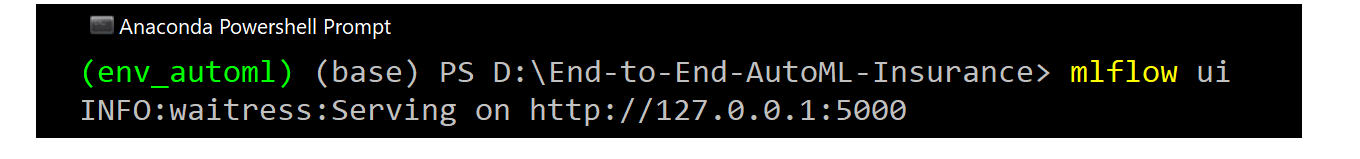

In [3]:
# Initialize MLFlow client
client = MlflowClient()

# Set up MlFlow experiment
experiment_name = 'automl-insurance'

try:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = client.get_experiment_by_name(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    
mlflow.set_experiment(experiment_name)

# Print experiment details
print(f"Name: {experiment_name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
print(f"Tracking uri: {mlflow.get_tracking_uri()}")

Name: automl-insurance
Experiment_id: 1
Artifact Location: file:///D:/Google%20Drive/Data%20Vault/GitHub/End-to-End-AutoML-Insurance/mlruns/1
Tags: {}
Lifecycle_stage: active
Tracking uri: file:///D:/Google%20Drive/Data%20Vault/GitHub/End-to-End-AutoML-Insurance/mlruns


___
<a name="automl"></a>
## (2) H2O AutoML Training with MLFlow Tracking

### Import training data
- Not splitting further into train/val set because 5-fold cross-val is applied by default in the AutoML training

In [4]:
# Import data directly as H2O frame
main_frame = h2o.import_file(path='data/processed/train.csv')

# Save data types of columns in H2O frame (for matching with test set during prediction)
with open('data/processed/train_col_types.json', 'w') as fp:
    json.dump(main_frame.types, fp)

# # Alternatively, can first import as pandas csv, then convert to H2O frame
# main_df = pd.read_csv('data/processed/train.csv')
# main_frame = h2o.H2OFrame(main_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
# Set predictor and target columns
target = 'Response'
predictors = [n for n in main_frame.col_names if n != target]

# Factorize target variable so that autoML tackles classification problem (instead of regression)
main_frame[target] = main_frame[target].asfactor()

# Visualize H2O frame structure
main_frame.head()

Gender,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,Region_Code_1,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Region_Code_19,Region_Code_2,Region_Code_20,Region_Code_21,Region_Code_22,Region_Code_23,Region_Code_24,Region_Code_25,Region_Code_26,Region_Code_27,Region_Code_28,Region_Code_29,Region_Code_3,Region_Code_30,Region_Code_31,Region_Code_32,Region_Code_33,Region_Code_34,Region_Code_35,Region_Code_36,Region_Code_37,Region_Code_38,Region_Code_39,Region_Code_4,Region_Code_40,Region_Code_41,Region_Code_42,Region_Code_43,Region_Code_44,Region_Code_45,Region_Code_46,Region_Code_47,Region_Code_48,Region_Code_49,Region_Code_5,Region_Code_50,Region_Code_51,Region_Code_52,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Vehicle_Age_lt_1Y,Vehicle_Age_gt_2Y,Vehicle_Damage_Yes,Policy_Sales_Channel_10,Policy_Sales_Channel_100,Policy_Sales_Channel_101,Policy_Sales_Channel_102,Policy_Sales_Channel_103,Policy_Sales_Channel_104,Policy_Sales_Channel_105,Policy_Sales_Channel_106,Policy_Sales_Channel_107,Policy_Sales_Channel_108,Policy_Sales_Channel_109,Policy_Sales_Channel_11,Policy_Sales_Channel_110,Policy_Sales_Channel_111,Policy_Sales_Channel_113,Policy_Sales_Channel_114,Policy_Sales_Channel_115,Policy_Sales_Channel_116,Policy_Sales_Channel_117,Policy_Sales_Channel_118,Policy_Sales_Channel_119,Policy_Sales_Channel_12,Policy_Sales_Channel_120,Policy_Sales_Channel_121,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_125,Policy_Sales_Channel_127,Policy_Sales_Channel_128,Policy_Sales_Channel_129,Policy_Sales_Channel_13,Policy_Sales_Channel_130,Policy_Sales_Channel_131,Policy_Sales_Channel_132,Policy_Sales_Channel_133,Policy_Sales_Channel_134,Policy_Sales_Channel_135,Policy_Sales_Channel_136,Policy_Sales_Channel_137,Policy_Sales_Channel_138,Policy_Sales_Channel_139,Policy_Sales_Channel_14,Policy_Sales_Channel_140,Policy_Sales_Channel_143,Policy_Sales_Channel_145,Policy_Sales_Channel_146,Policy_Sales_Channel_147,Policy_Sales_Channel_148,Policy_Sales_Channel_149,Policy_Sales_Channel_15,Policy_Sales_Channel_150,Policy_Sales_Channel_151,Policy_Sales_Channel_152,Policy_Sales_Channel_153,Policy_Sales_Channel_154,Policy_Sales_Channel_155,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_158,Policy_Sales_Channel_159,Policy_Sales_Channel_16,Policy_Sales_Channel_160,Policy_Sales_Channel_163,Policy_Sales_Channel_17,Policy_Sales_Channel_18,Policy_Sales_Channel_19,Policy_Sales_Channel_2,Policy_Sales_Channel_20,Policy_Sales_Channel_21,Policy_Sales_Channel_22,Policy_Sales_Channel_23,Policy_Sales_Channel_24,Policy_Sales_Channel_25,Policy_Sales_Channel_26,Policy_Sales_Channel_27,Policy_Sales_Channel_28,Policy_Sales_Channel_29,Policy_Sales_Channel_3,Policy_Sales_Channel_30,Policy_Sales_Channel_31,Policy_Sales_Channel_32,Policy_Sales_Channel_34,Policy_Sales_Channel_35,Policy_Sales_Channel_36,Policy_Sales_Channel_37,Policy_Sales_Channel_38,Policy_Sales_Channel_39,Policy_Sales_Channel_4,Policy_Sales_Channel_40,Policy_Sales_Channel_41,Policy_Sales_Channel_42,Policy_Sales_Channel_44,Policy_Sales_Channel_45,Policy_Sales_Channel_46,Policy_Sales_Channel_47,Policy_Sales_Channel_48,Policy_Sales_Channel_49,Policy_Sales_Channel_51,Policy_Sales_Channel_52,Policy_Sales_Channel_53,Policy_Sales_Channel_54,Policy_Sales_Channel_55,Policy_Sales_Channel_56,Policy_Sales_Channel_57,Policy_Sales_Channel_58,Policy_Sales_Channel_59,Policy_Sales_Channel_6,Policy_Sales_Channel_60,Policy_Sales_Channel_61,Policy_Sales_Channel_62,Policy_Sales_Channel_63,Policy_Sales_Channel_64,Policy_Sales_Channel_65,Policy_Sales_Channel_66,Policy_Sales_Channel_67,Policy_Sales_Channel_68,Policy_Sales_Channel_69,Policy_Sales_Channel_7,Policy_Sales_Channel_70,Policy_Sales_Channel_71,Policy_Sales_Channel_73,Policy_Sales_Channel_74,Policy_Sales_Channel_75,Policy_Sales_Channel_76,Policy_Sales_Channel_78,Policy_Sales_Channel_79,Policy_Sales_Channel_

### Start H2O AutoML training with MLflow tracking

In [6]:
# Wrap autoML training with MLflow
with mlflow.start_run():
    aml = H2OAutoML(
                    max_models=13, # Run AutoML for n base models
                    seed=42, 
                    balance_classes=True, # Our target classes are imbalanced, so we set this to True
                    sort_metric='logloss', # Sort models by logloss (main metric for multi-classification)
                    verbosity='info', # Turn on verbose info
                    exclude_algos = ['GLM', 'DRF'], # Specify which algorithms to exclude
                   )
    
    aml.train(x=predictors, y=target, training_frame=main_frame)
    
    # Set metrics to log
    mlflow.log_metric("log_loss", aml.leader.logloss())
    mlflow.log_metric("AUC", aml.leader.auc())
    
    # Log best model (mlflow.h2o module provides API for logging & loading H2O models)
    mlflow.h2o.log_model(aml.leader, 
                         artifact_path="model"
                        )
    
    model_uri = mlflow.get_artifact_uri("model")
    print(model_uri)
    
    # Print and view AutoML Leaderboard
    lb = get_leaderboard(aml, extra_columns='ALL')
    print(lb.head(rows=lb.nrows))
    
    # Get IDs of current experiment run
    exp_id = experiment.experiment_id
    run_id = mlflow.active_run().info.run_id
    
    # Save leaderboard as CSV
    lb_path = f'mlruns/{exp_id}/{run_id}/artifacts/model/leaderboard.csv'
    lb.as_data_frame().to_csv(lb_path, index=False) 
    print(f'Leaderboard saved in {lb_path}')

AutoML progress: |
23:31:10.730: Project: AutoML_1_20211217_233110
23:31:10.746: Setting stopping tolerance adaptively based on the training frame: 0.0033065124063248246
23:31:10.746: Build control seed: 42
23:31:10.746: training frame: Frame key: AutoML_1_20211217_233110_training_py_1_sid_af79    cols: 208    rows: 91466  chunks: 32    size: 2498152  checksum: -278537779907193698
23:31:10.746: validation frame: NULL
23:31:10.746: leaderboard frame: NULL
23:31:10.746: blending frame: NULL
23:31:10.746: response column: Response
23:31:10.746: fold column: null
23:31:10.746: weights column: null
23:31:10.761: AutoML: XGBoost is not available; skipping it.
23:31:10.761: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_4_AutoML_1_20211217_233110,0.267856,0.857465,0.372007,0.223421,0.296223,0.0877481,2622,0.032762,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211217_233110,0.267923,0.857422,0.37199,0.237029,0.29623,0.087752,2570,0.02495,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211217_233110,0.267939,0.857353,0.372175,0.221775,0.296227,0.0877502,2162,0.014456,StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_1_20211217_233110,0.268007,0.857387,0.371316,0.218913,0.296297,0.0877916,28027,0.03566,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211217_233110,0.268216,0.856728,0.367925,0.232122,0.296417,0.0878632,1945,0.005878,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20211217_233110,0.268274,0.856674,0.36722,0.229264,0.296462,0.0878895,20307,0.005849,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20211217_233110,0.268298,0.856724,0.368794,0.231362,0.296413,0.0878609,1975,0.005201,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211217_233110,0.268347,0.856833,0.371182,0.233061,0.296332,0.0878124,2508,0.01277,StackedEnsemble
GBM_2_AutoML_1_20211217_233110,0.26879,0.856332,0.369063,0.22587,0.296586,0.087963,8169,0.003527,GBM
GBM_5_AutoML_1_20211217_233110,0.268806,0.856272,0.370266,0.229176,0.296659,0.0880064,7301,0.004023,GBM



Leaderboard saved in mlruns/1/8e2589f8cb774d03ac694ef04abff60b/artifacts/model/leaderboard.csv


### View AutoML logs

In [7]:
# Get AutoML event log
log = aml.event_log
log

timestamp,level,stage,message,name,value
23:31:10.730,Info,Workflow,Project: AutoML_1_20211217_233110,,
23:31:10.746,Info,Validation,Setting stopping tolerance adaptively based on the training frame: 0.0033065124063248246,,
23:31:10.746,Info,Validation,Build control seed: 42,,
23:31:10.746,Info,DataImport,training frame: Frame key: AutoML_1_20211217_233110_training_py_1_sid_af79 cols: 208 rows: 91466 chunks: 32 size: 2498152 checksum: -278537779907193698,,
23:31:10.746,Info,DataImport,validation frame: NULL,,
23:31:10.746,Info,DataImport,leaderboard frame: NULL,,
23:31:10.746,Info,DataImport,blending frame: NULL,,
23:31:10.746,Info,DataImport,response column: Response,,
23:31:10.746,Info,DataImport,fold column: null,,
23:31:10.746,Info,DataImport,weights column: null,,


### View best model

In [8]:
# Leader (best) model stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_1_20211217_233110

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08577154981492771
RMSE: 0.29286780262590784
LogLoss: 0.2590355903548521
Null degrees of freedom: 9974
Residual degrees of freedom: 9964
Null deviance: 7645.684519489879
Residual deviance: 5167.760027579298
AIC: 5189.760027579298
AUC: 0.8801947060092007
AUCPR: 0.4585201918789183
Gini: 0.7603894120184014

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25580290154645857: 


,,0,1,Error,Rate
0,0,6932.0,1763.0,0.2028,(1763.0/8695.0)
1,1,267.0,1013.0,0.2086,(267.0/1280.0)
2,Total,7199.0,2776.0,0.2035,(2030.0/9975.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.255803,0.499507,179.0
1,max f2,0.136654,0.669569,274.0
2,max f0point5,0.330081,0.457682,111.0
3,max accuracy,0.398050,0.877193,39.0
4,max precision,0.438516,0.857143,12.0
5,max recall,0.020283,1.000000,370.0
6,max specificity,0.486942,0.999885,0.0
7,max absolute_mcc,0.227937,0.443060,201.0
8,max min_per_class_accuracy,0.252819,0.794531,182.0
9,max mean_per_class_accuracy,0.136654,0.817163,274.0



Gains/Lift Table: Avg response rate: 12.83 %, avg score: 12.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010025,0.424264,5.533008,5.533008,0.710000,0.439002,0.710000,0.439002,0.055469,0.055469,453.300781,453.300781,0.052133
1,2,0.020050,0.405179,4.052344,4.792676,0.520000,0.415044,0.615000,0.427023,0.040625,0.096094,305.234375,379.267578,0.087238
2,3,0.030075,0.396024,4.130273,4.571875,0.530000,0.400295,0.586667,0.418114,0.041406,0.137500,313.027344,357.187500,0.123239
3,4,0.040000,0.388829,3.384825,4.277344,0.434343,0.392213,0.548872,0.411687,0.033594,0.171094,238.482481,327.734375,0.150392
4,5,0.050025,0.382674,3.428906,4.107316,0.440000,0.385803,0.527054,0.406500,0.034375,0.205469,242.890625,310.731619,0.178327
5,6,0.100050,0.359232,3.263989,3.685653,0.418838,0.371881,0.472946,0.389191,0.163281,0.368750,226.398892,268.565256,0.308255
6,7,0.150075,0.333501,2.967263,3.446189,0.380762,0.346161,0.442218,0.374847,0.148438,0.517188,196.726265,244.618925,0.421155
7,8,0.200000,0.310476,2.112552,3.113281,0.271084,0.322300,0.399499,0.361730,0.105469,0.622656,111.255177,211.328125,0.484876
8,9,0.300050,0.234700,2.045850,2.757352,0.262525,0.276200,0.353826,0.333211,0.204687,0.827344,104.584951,175.735179,0.604917
9,10,0.400000,0.131132,1.234994,2.376953,0.158475,0.182659,0.305013,0.295592,0.123438,0.950781,23.499404,137.695312,0.631862




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08774809360575106
RMSE: 0.2962230470536536
LogLoss: 0.26785559999526554
Null degrees of freedom: 91465
Residual degrees of freedom: 91455
Null deviance: 68812.23855635656
Residual deviance: 48999.360618333914
AIC: 49021.360618333914
AUC: 0.8574645561869488
AUCPR: 0.37200687519668696
Gini: 0.7149291123738977

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22896137305622571: 


,,0,1,Error,Rate
0,0,61768.0,18294.0,0.2285,(18294.0/80062.0)
1,1,2490.0,8914.0,0.2183,(2490.0/11404.0)
2,Total,64258.0,27208.0,0.2272,(20784.0/91466.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.228961,0.461722,199.0
1,max f2,0.138435,0.641964,273.0
2,max f0point5,0.319260,0.395540,117.0
3,max accuracy,0.456269,0.875495,9.0
4,max precision,0.737694,1.000000,0.0
5,max recall,0.000343,1.000000,399.0
6,max specificity,0.737694,1.000000,0.0
7,max absolute_mcc,0.161405,0.407708,253.0
8,max min_per_class_accuracy,0.231521,0.774300,197.0
9,max mean_per_class_accuracy,0.138435,0.799973,273.0



Gains/Lift Table: Avg response rate: 12.47 %, avg score: 12.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.413825,3.637722,3.637722,0.453552,0.432505,0.453552,0.432505,0.036391,0.036391,263.772178,263.772178,0.030146
1,2,0.020007,0.398281,3.593894,3.615808,0.448087,0.405239,0.450820,0.418872,0.035952,0.072343,259.389381,261.580780,0.059790
2,3,0.030000,0.388650,3.404772,3.545514,0.424508,0.393114,0.442055,0.410292,0.034023,0.106366,240.477179,254.551373,0.087244
3,4,0.040004,0.381449,3.278332,3.478700,0.408743,0.384850,0.433725,0.403930,0.032796,0.139162,227.833240,247.870015,0.113282
4,5,0.050008,0.376192,3.339692,3.450892,0.416393,0.378774,0.430258,0.398897,0.033409,0.172571,233.969157,245.089235,0.140021
5,6,0.100004,0.352488,3.020191,3.235565,0.376558,0.364895,0.403411,0.381898,0.151000,0.323571,202.019110,223.556527,0.255411
6,7,0.150001,0.327705,2.657137,3.042770,0.331292,0.339745,0.379373,0.367848,0.132848,0.456419,165.713677,204.276983,0.350064
7,8,0.200009,0.304425,2.456657,2.896225,0.306296,0.316740,0.361102,0.355070,0.122852,0.579270,145.665660,189.622550,0.433284
8,9,0.300002,0.226130,2.064323,2.618945,0.257380,0.268813,0.326531,0.326320,0.206419,0.785689,106.432342,161.894502,0.554868
9,10,0.400007,0.127353,1.385418,2.310555,0.172734,0.176642,0.288080,0.288899,0.138548,0.924237,38.541819,131.055488,0.598902


#### Learning Curve Plot

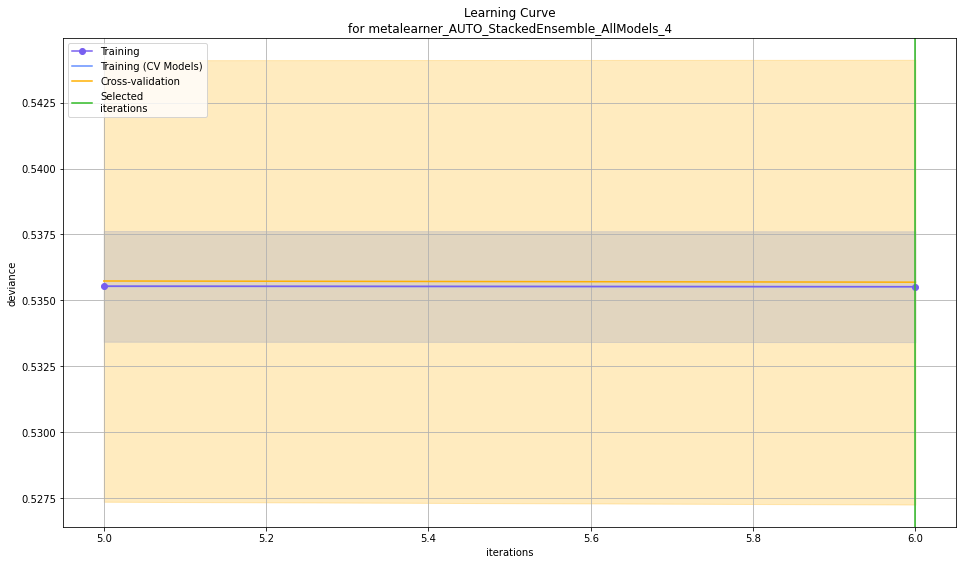

In [9]:
# Display learning curve
learning_curve_plot = aml.leader.learning_curve_plot()

___
<a name="predict"></a>
## (3) Predict with H2O AutoML Best Model

### Prepare test data

In [10]:
# Import test data
test_frame = h2o.import_file(path='data/processed/test.csv')

# Drop ID column for test set
X_test_frame = test_frame.drop('Response')
y_test_frame = test_frame[:, 'Response']

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Load leader model from MLflow saved in artifacts

In [11]:
# Get dataframe of all runs
all_experiments = [exp.experiment_id for exp in client.list_experiments()]
runs = mlflow.search_runs(experiment_ids=all_experiments, run_view_type=ViewType.ALL)

# Identify best model (experiment id and run id) amongst all runs in the experiment
run_id, exp_id = runs.loc[runs['metrics.log_loss'].idxmin()]['run_id'], runs.loc[runs['metrics.log_loss'].idxmin()]['experiment_id']
run_id, exp_id

('8e2589f8cb774d03ac694ef04abff60b', '1')

In [12]:
# Load best model (AutoML leader)
best_model = mlflow.h2o.load_model(f"mlruns/{exp_id}/{run_id}/artifacts/model/")

# Generate predictions with best model (output is H2O frame)
preds_frame = best_model.predict(X_test_frame)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [13]:
# Get y values (ground truth and predicted)
y_pred = preds_frame.as_data_frame()['predict']
y_true = y_test_frame.as_data_frame()['Response']

### Get Performance Metrics

In [14]:
from sklearn.metrics import f1_score, accuracy_score
f1_score(y_true, y_pred)

0.45149950565747554

In [15]:
accuracy_score(y_true, y_pred)

0.781650413259282

___
<a name="explain"></a>
## (4) H2O Model Explainability
- More info: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#output-explanations

In [ ]:
# Setup validation set (15%) for model explainability
_, _, val_frame = main_frame.split_frame(ratios=[.7, .15])

# Explain a single H2O model (NOTE: This takes a long time to run)
exm = best_model.explain(val_frame)

#### Individual Conditional Expectation (ICE) Plot
- Visualizes the interaction (or dependence) between the predicted target response and a set of input features of interest

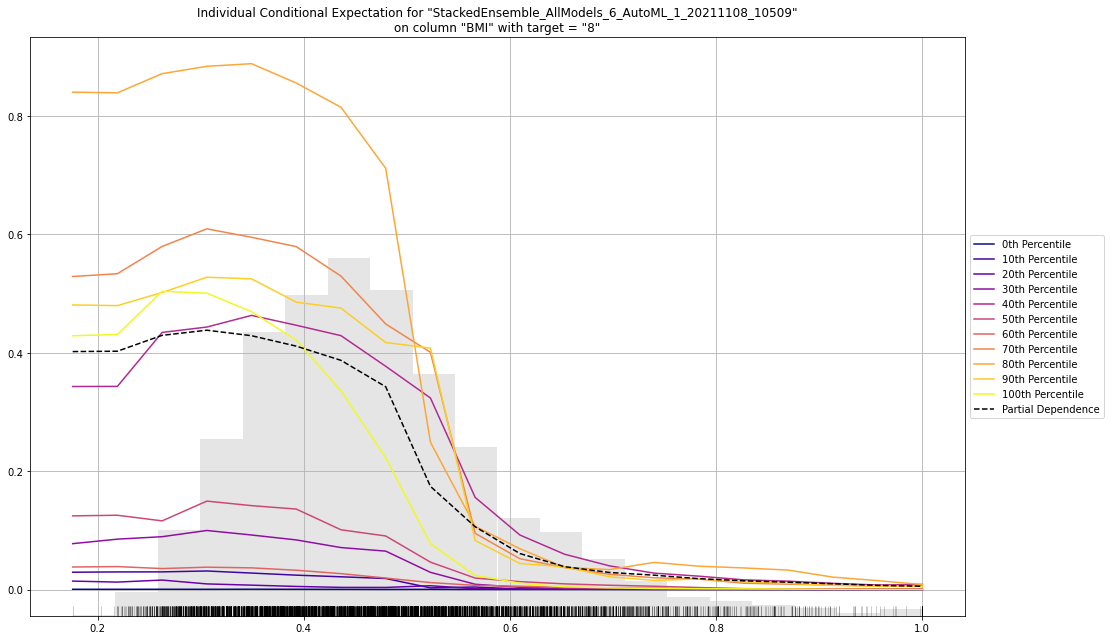

In [19]:
# Displaying sample ICE plot
# ice_plot = best_model.ice_plot(val_frame, target='1', column='Vintage')